**Using Copernicus Marine Toolbox**
- Dataset Info: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D
- Time Range: 4th September 1997 - 22nd September 2025
- Processing Level: Level 3
- Sensor: Harmonized Multisensor

In [1]:
##import copernicusmarine
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
chl_data = xr.open_mfdataset('C:\\Users\\ADMIN\\marine\\monsoon\\data\\*.nc', combine='by_coords')

In [3]:
chl_data['CHL']

<xarray.DataArray 'CHL' (time: 10246, latitude: 144, longitude: 240)> Size: 1GB
dask.array<concatenate, shape=(10246, 144, 240), dtype=float32, chunksize=(366, 144, 240), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
  * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
  * time       (time) datetime64[ns] 82kB 1997-09-05 1997-09-06 ... 2025-09-23
Attributes:
    standard_name:  mass_concentration_of_chlorophyll_a_in_sea_water
    valid_min:      0.0
    long_name:      Chlorophyll-a concentration - Mean of the binned pixels
    valid_max:      1000.0
    units:          milligram m-3

In [4]:
season_dict = {
    'North East Monsoon': [1, 2, 12],
    'South East Monsoon': [6, 7, 8],
    'Long Rains': [3, 4, 5],
    'Short Rains': [9, 10, 11]
}

In [5]:
def filter_by_szn(dataset:xr.Dataset, seasons_info:dict, season:str):
    filtered_ds = dataset.isel(time=dataset.time.dt.month.isin(seasons_info[season]))
    print(f"data filtered to {season} season")
    return filtered_ds

In [6]:
def composite_season(filtered_data:xr.Dataset, dimension:str):
    seasonal_composite = filtered_data.mean(dim=dimension)
    return seasonal_composite

In [7]:
def get_szn_timeseries(filtered_data:xr.Dataset, dimensions:list):
    daily_average = filtered_data.mean(dimensions)
    yearly_average = daily_average.groupby(daily_average.time.dt.year).mean()
    return yearly_average

In [8]:
def generate_title(season:str):
    title = "Average Chlorophyll-a Concentration Per Year in Kenya EEZ during {0} season (1997-2025)".format(season)
    return title

In [9]:
def generate_plot_path(season:str):
    plot_name = "{0}_timeseries_plot.png".format(season)
    plot_path = os.path.join("/monsoon", "plots", plot_name)
    return plot_path

In [10]:
generate_plot_path(season='long rains')

'/monsoon\\plots\\long rains_timeseries_plot.png'

In [11]:
composites = {}

for season in season_dict.keys():
    composite = chl_data.pipe(filter_by_szn, seasons_info=season_dict, season=season).pipe(composite_season, dimension='time')
    composites[season] = composite
composites

data filtered to North East Monsoon season
data filtered to South East Monsoon season
data filtered to Long Rains season
data filtered to Short Rains season


{'North East Monsoon': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
 Data variables:
     CHL        (latitude, longitude) float32 138kB dask.array<chunksize=(144, 240), meta=np.ndarray>,
 'South East Monsoon': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longitude) float32 960B 38.02 38.06 38.1 ... 47.9 47.94 47.98
 Data variables:
     CHL        (latitude, longitude) float32 138kB dask.array<chunksize=(144, 240), meta=np.ndarray>,
 'Long Rains': <xarray.Dataset> Size: 140kB
 Dimensions:    (latitude: 144, longitude: 240)
 Coordinates:
   * latitude   (latitude) float32 576B -5.979 -5.938 -5.896 ... -0.0625 -0.02084
   * longitude  (longi

In [12]:
time_series = {}
for season in season_dict.keys():
    yearly_averages = chl_data.pipe(filter_by_szn, seasons_info=season_dict, season=season).pipe(get_szn_timeseries, dimensions=['latitude', 'longitude'])
    time_series[season] = yearly_averages

time_series

data filtered to North East Monsoon season
data filtered to South East Monsoon season
data filtered to Long Rains season
data filtered to Short Rains season


{'North East Monsoon': <xarray.Dataset> Size: 348B
 Dimensions:  (year: 29)
 Coordinates:
   * year     (year) int64 232B 1997 1998 1999 2000 2001 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 116B dask.array<chunksize=(1,), meta=np.ndarray>,
 'South East Monsoon': <xarray.Dataset> Size: 336B
 Dimensions:  (year: 28)
 Coordinates:
   * year     (year) int64 224B 1998 1999 2000 2001 2002 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 112B dask.array<chunksize=(1,), meta=np.ndarray>,
 'Long Rains': <xarray.Dataset> Size: 336B
 Dimensions:  (year: 28)
 Coordinates:
   * year     (year) int64 224B 1998 1999 2000 2001 2002 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float32 112B dask.array<chunksize=(1,), meta=np.ndarray>,
 'Short Rains': <xarray.Dataset> Size: 348B
 Dimensions:  (year: 29)
 Coordinates:
   * year     (year) int64 232B 1997 1998 1999 2000 2001 ... 2022 2023 2024 2025
 Data variables:
     CHL      (year) float

In [44]:
def timeseries_plotter(timeseries:xr.Dataset, season=None):

    chl = timeseries['CHL'].values
    years = timeseries['year'].values
    xmin, xmax = years.min(), years.max()
    ymin, ymax = 0, chl.max()

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(years, chl, marker='.', color='green')

    
    title = generate_title(season=season)
    ax.set_title(title)

    ax.set_xlabel("Year")
    ax.set_ylabel("Chlorophyll Concentration in mg per cubic meter")

    xticks = np.arange(xmin, (xmax + 2), 2)
    xtickla = [f'{xtick}' for xtick in xticks]
    ax.xaxis.set_ticks(xticks)
    ax.xaxis.set_ticklabels(xtickla)

    yticks = np.linspace(ymin, (ymax*1.5), 8)
    ytickla = [f'{ytick: 1.2f}' for ytick in yticks]
    ax.yaxis.set_ticks(yticks)
    ax.yaxis.set_ticklabels(ytickla)

    ax.spines[['top', 'right']].set_visible(False)
    ax.grid(visible=True, which='major', axis='both', color='grey', linestyle='--', linewidth=0.6)
    plot_name = generate_plot_path(season=season)
    ##plt.savefig(plot_name)



In [14]:
##timeseries_plotter(timeseries=time_series['short rains'].compute(), season='short rains')

In [15]:
##np.arange(time_series['north east monsoon'].year.min(), (time_series['north east monsoon'].year.max() + 2), 2)

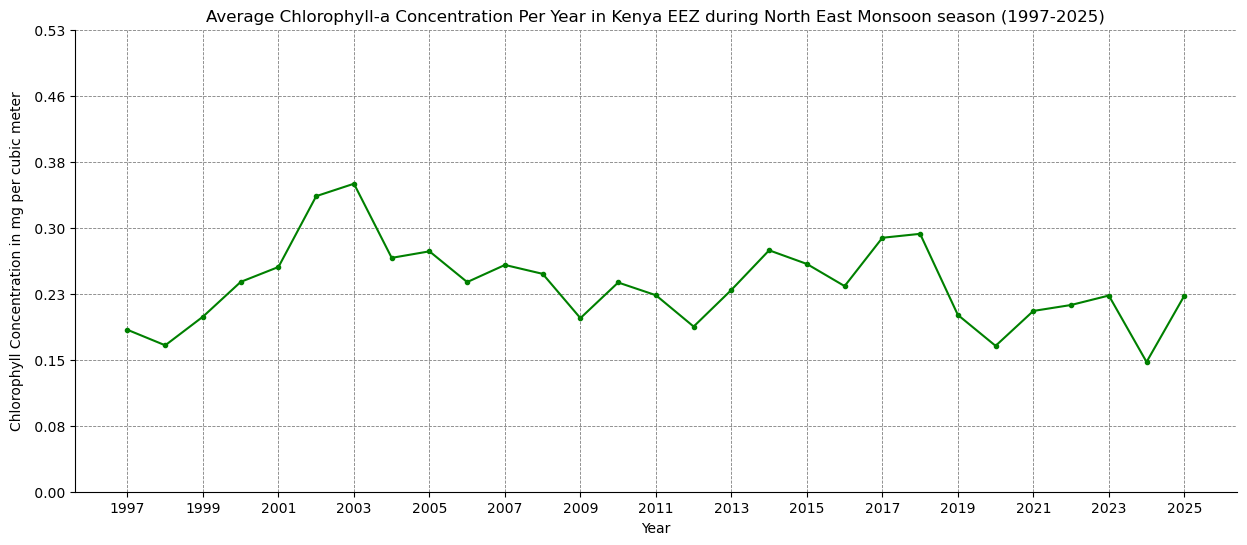

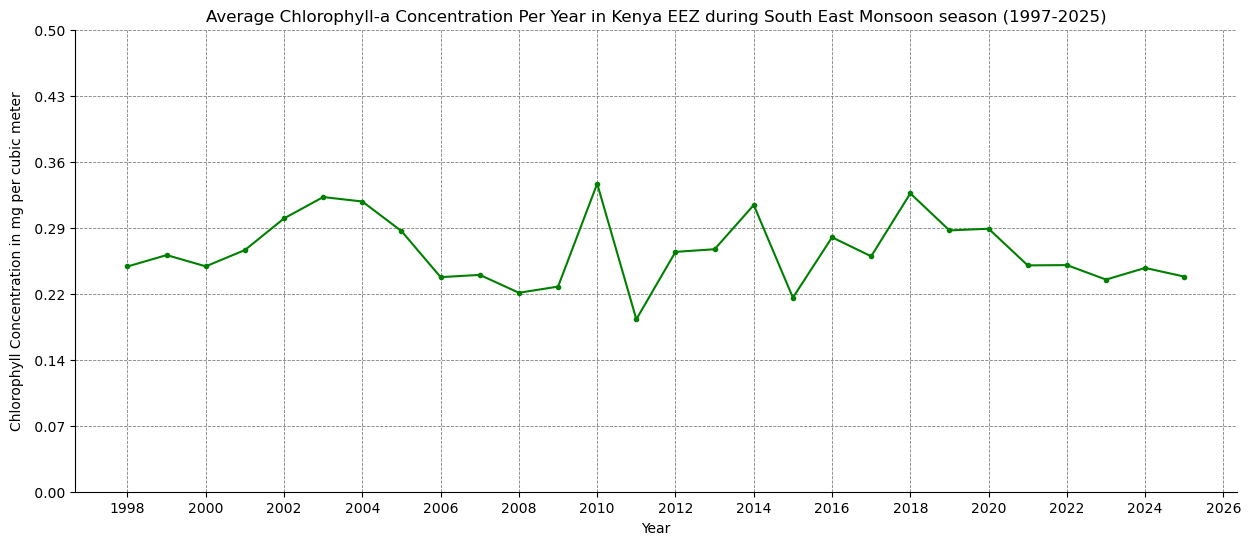

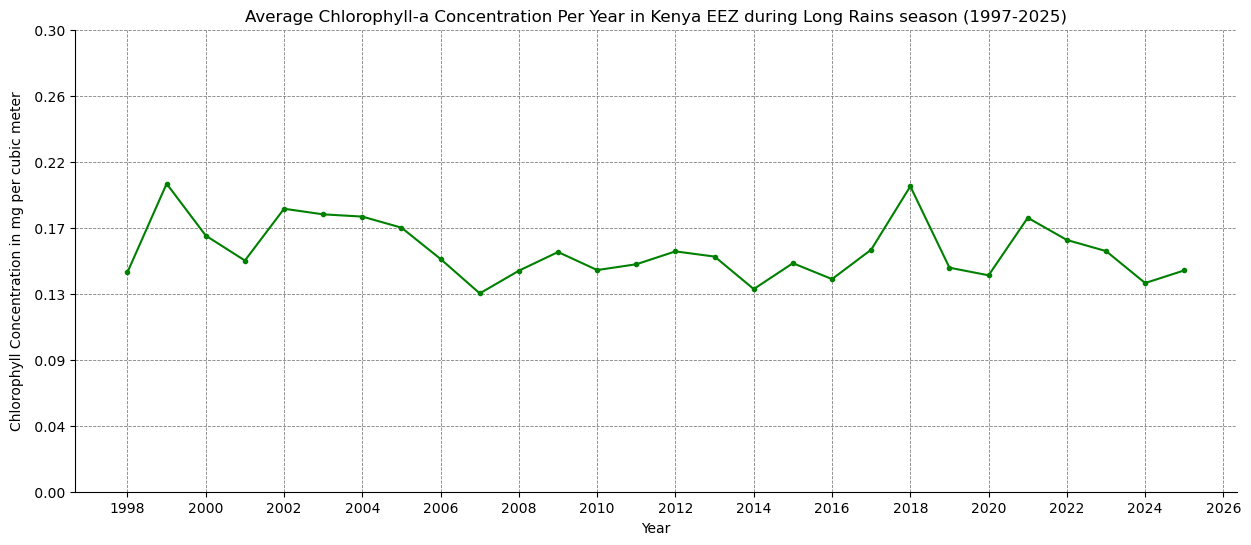

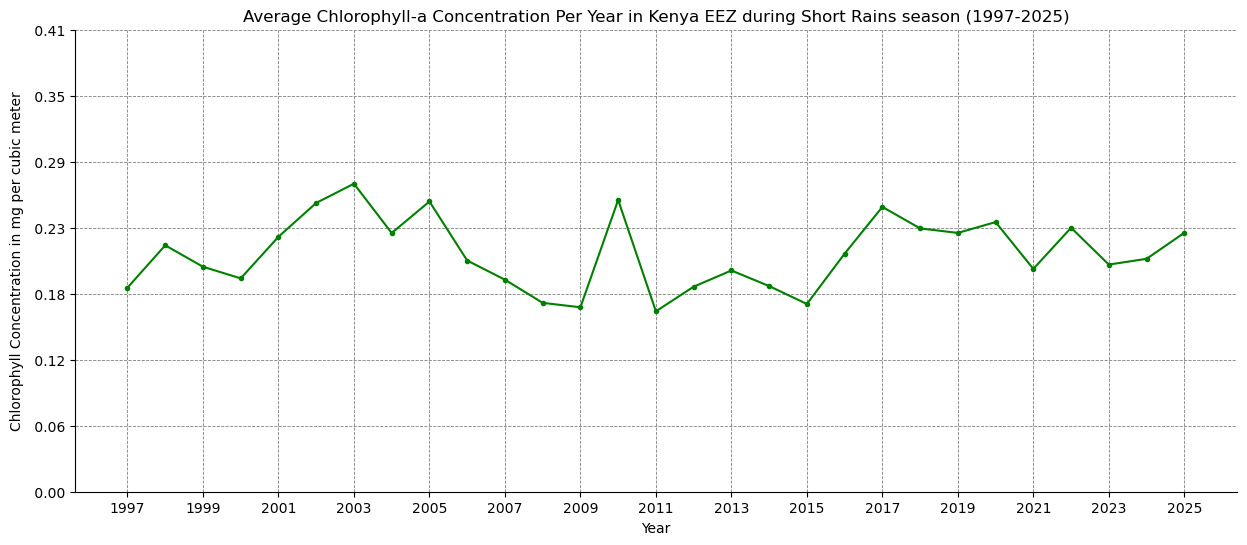

In [45]:
for season, ts in time_series.items():
    timeseries_plotter(timeseries=ts.compute(), season=season)

In [42]:
def write_raster(composite:xr.Dataset, parent_folder:str, CRS:str, season:str):

    os.chdir(parent_folder)
    parent_folder = os.getcwd()
    composite = composite.rio.write_crs(CRS)
    raster_name = "{0}\\{1}_composite.tif".format(parent_folder, season)
    composite.rio.to_raster(raster_name)
    print(composite.rio.crs)
    print(raster_name)


In [43]:
parent_path = "C:\\Users\\ADMIN\\marine\\monsoon\\data\\rasters"
for season, composite in composites.items():
    write_raster(composite=composite, parent_folder=parent_path, CRS='EPSG:4326', season=season)

EPSG:4326
C:\Users\ADMIN\marine\monsoon\data\rasters\North East Monsoon_composite.tif
EPSG:4326
C:\Users\ADMIN\marine\monsoon\data\rasters\South East Monsoon_composite.tif
EPSG:4326
C:\Users\ADMIN\marine\monsoon\data\rasters\Long Rains_composite.tif
EPSG:4326
C:\Users\ADMIN\marine\monsoon\data\rasters\Short Rains_composite.tif
